In [1]:
import numpy as np
import matplotlib.pyplot as plt
#H='/Users/hongwang/Downloads/plot_uq_erescale/noise_noiserescale/uq_noise_rescale_noiserescalr/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
H='/content/drive/My Drive/galaxy_deblur/new_10k_data/noise/'

In [4]:
!ls '/content/drive/My Drive/galaxy_deblur/new_10k_data/noise/'

new_data_noise_original_clamp.npz  uq_noise_rescale_noiserescale
new_data_noise_original.npz	   uq_noise_rescale_noiserescale_clamp


In [5]:
#quadrature add
sadd = lambda x,y : np.sqrt(x**2+y**2)
def three_bins(q): # split quantity in three bins
    N=len(q)
    mlim1, mlim2 = np.sort(q)[[N//3, 2*N//3]]
    bin1 = np.where(q<=mlim1)
    bin2 = np.where((q>mlim1)&(q<=mlim2))
    bin3 = np.where((q>mlim2))
    return bin1,bin2,bin3

In [6]:
# True data
o = np.load(H+'new_data_noise_original_clamp.npz')
## this one still has the old definition, so we need to calculate
#e1_pred = (o['Mu20_pred']-o['Mu02_pred'])/(o['Mu20_pred']+o['Mu02_pred'])
#e2_pred = (2*o['Mu11_pred'])/(o['Mu20_pred']+o['Mu02_pred'])
e1_pred = o['e1_pred']
e2_pred = o['e2_pred']
print(e1_pred.min(),e1_pred.max())
print(e2_pred.min(),e2_pred.max())
                                          
# PSF
psf=np.load(H+"../new_data_kernel_clamp.npz")
psf_e1=psf['e1_kernel']
psf_e2=psf['e2_kernel']
psf_e = sadd(psf_e1,psf_e2)
pbin1,pbin2,pbin3 = three_bins(psf_e)

-0.7598984241485596 0.7375916242599487
-0.8042968511581421 0.8277348279953003


In [7]:
## Let's get noise realizations
noise_e1 = []
noise_e2 = []
noise_m02 = []
noise_m20 = []
noise_m11 = []

In [8]:
for i in range(112):
    t_ = np.load(H+f'uq_noise_rescale_noiserescale_clamp/results_noise{i}.npz')
    noise_e1.append(t_['e1_pred'])
    noise_e2.append(t_['e2_pred'])
    noise_m20.append(t_['Mu20_pred'])
    noise_m02.append(t_['Mu02_pred'])
    noise_m11.append(t_['Mu11_pred'])
    if i==0:
        e1_true = t_['e1_true']
        e2_true = t_['e2_true']
        mag = np.log10(t_['M00_true'])


In [9]:
e1_noise = np.array(noise_e1).T
e2_noise = np.array(noise_e2).T
m20_noise = np.array(noise_m20).T
m02_noise = np.array(noise_m02).T
m11_noise = np.array(noise_m11).T

print(m20_noise.min(), m20_noise.max())
## get around shitty values
#m20_noise[m20_noise<0] = np.NaN
#m02_noise[m02_noise<0] = np.NaN
#e1_noise = (m20_noise-m02_noise)/(m20_noise+m02_noise)
#e2_noise = (2*m11_noise)/(m20_noise+m02_noise)
print(np.shape(m20_noise<0))
e1_pred_avgnoise = e1_noise.mean(axis=1)
e2_pred_avgnoise = e2_noise.mean(axis=1)

1.3840235471725464 76.4969482421875
(10000, 112)


In [10]:
# let's make three mag bins.
mbin1, mbin2, mbin3 = three_bins(mag)

In [11]:
print(e1_pred_avgnoise.min(),e1_pred_avgnoise.max())
print(e2_pred_avgnoise.min(),e2_pred_avgnoise.max())

assert (np.all(sadd(psf_e1,psf_e2)<1))
assert (np.all(sadd(e1_true,e2_true)<1))
assert (np.all(sadd(e1_pred,e2_pred)<1))
assert (np.all(sadd(e1_pred_avgnoise,e2_pred_avgnoise)<1))

-0.7491479782121522 0.7152138065014567
-0.7997679013226714 0.8142042521919522


In [12]:
## let us just ignore this issue and see if higher SNR have lower error
err_e1 = np.sqrt(np.var(e1_noise,axis=1))
err_e2 = np.sqrt(np.var(e2_noise,axis=1))

[]

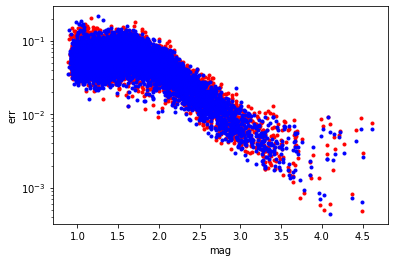

In [13]:
plt.plot(mag,err_e2,'r.')
plt.plot(mag,err_e1,'b.')
plt.xlabel('mag')
plt.ylabel('err')
plt.semilogy()
## this is beautifiul

[]

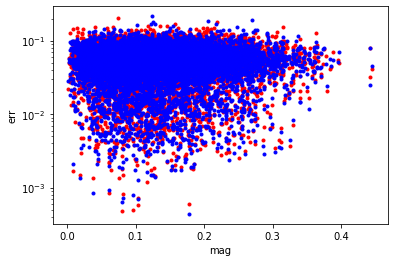

In [14]:
## is if PSF sizes affets

plt.plot(psf_e,err_e2,'r.')
plt.plot(psf_e,err_e1,'b.')
plt.xlabel('mag')
plt.ylabel('err')
plt.semilogy()
## not really

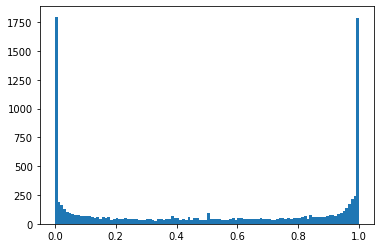

In [16]:
# now see where in cdf the truth lies. Ideally, this number should be distributed between 0 and 1.
cdfpos = np.array([np.sum(t<dist)/112 for t,dist in zip(e1_true,e1_noise)])
### all in all, way too many outliers
_=plt.hist(cdfpos, bins=110)

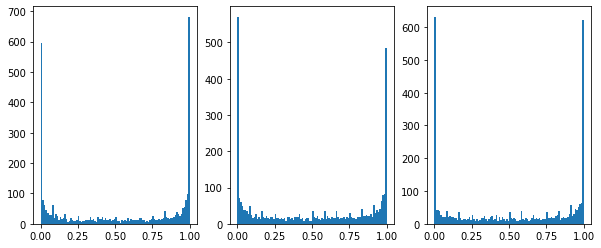

In [20]:
#split by mag bins
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
_=plt.hist(cdfpos[mbin1], bins=100)
plt.subplot(1,3,2)
_=plt.hist(cdfpos[mbin2], bins=100)
plt.subplot(1,3,3)
_=plt.hist(cdfpos[mbin3], bins=100)

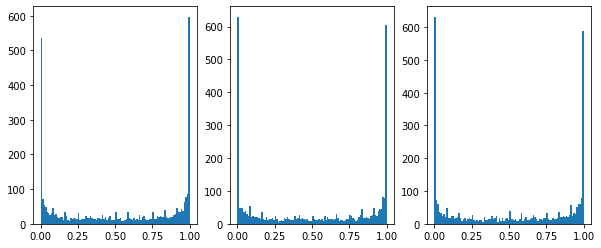

In [21]:
# same but for psf bins
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
_=plt.hist(cdfpos[pbin1], bins=100)
plt.subplot(1,3,2)
_=plt.hist(cdfpos[pbin2], bins=100)
plt.subplot(1,3,3)
_=plt.hist(cdfpos[pbin3], bins=100)

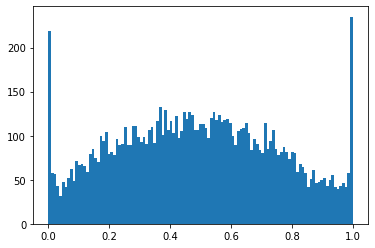

In [27]:
# do the same for predicted position. This should surely work
# For Guassian, it should around half
cdfposp = np.array([np.sum(t<dist)/112 for t,dist in zip(e1_pred,e1_noise)])
### all in all, way too many outliers
_=plt.hist(cdfposp, bins=113)

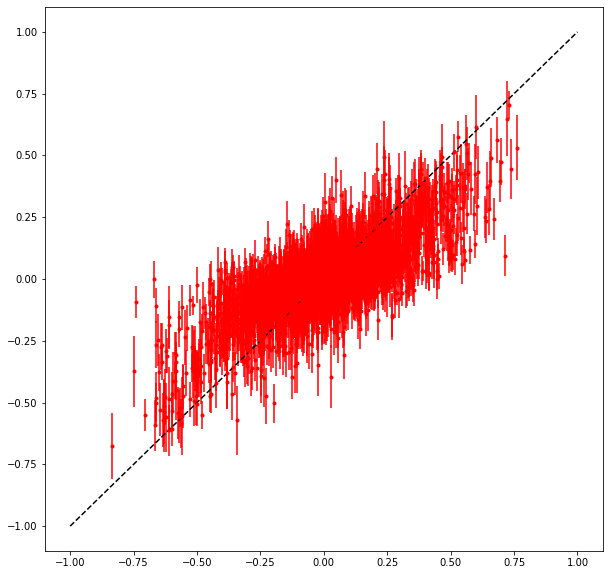

In [28]:
plt.figure(figsize=(10,10))
plt.errorbar(e1_true[mbin2],e1_pred[mbin2], yerr=err_e1[mbin2],fmt='r.')
plt.plot([-1,1],[-1,1],'k--')

-0.0005080913115679188 0.002304657792958452


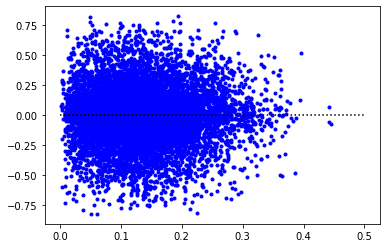

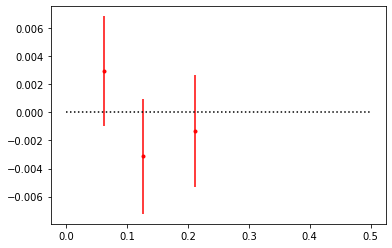

In [29]:
## see correlations between psf_e and true data, should be none
plt.figure()
q= (e1_true*psf_e1+e2_true*psf_e2)/psf_e
plt.plot(psf_e, q,'b.')
print (q.mean(), np.sqrt(q.var())/np.sqrt(10000))
plt.plot([0,0.5],[0,0],'k:')
plt.figure()
# and plot 3 bins
for pbin in [pbin1,pbin2,pbin3]:
    plt.errorbar(psf_e[pbin].mean(), q[pbin].mean(),yerr=np.sqrt(q[pbin].var()/len(pbin[0])),fmt='r.')
plt.plot([0,0.5],[0,0],'k:')

-0.0005080913115679188 0.002304657792958452


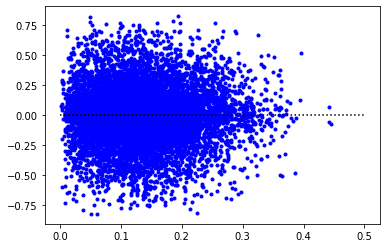

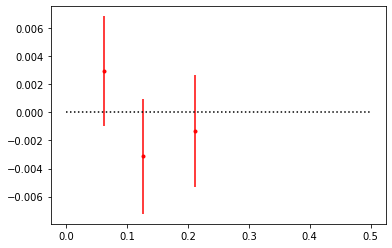

In [30]:
## see correlations between psf_e and true data, should be none
plt.figure()
q= (e1_true*psf_e1+e2_true*psf_e2)/psf_e
plt.plot(psf_e, q,'b.')
print (q.mean(), np.sqrt(q.var())/np.sqrt(10000))
plt.plot([0,0.5],[0,0],'k:')
plt.figure()
# and plot 3 bins
for pbin in [pbin1,pbin2,pbin3]:
    plt.errorbar(psf_e[pbin].mean(), q[pbin].mean(),yerr=np.sqrt(q[pbin].var()/len(pbin[0])),fmt='r.')
plt.plot([0,0.5],[0,0],'k:')

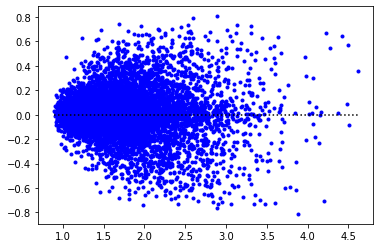

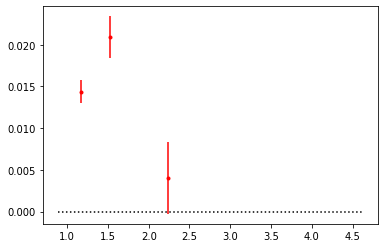

In [31]:
### let's do the same but split by magnitude
## see correlations between psf_e and true data, should be none
q= (e1_pred*psf_e1+e2_pred*psf_e2)/psf_e
plt.plot(mag, q,'b.')
plt.plot([mag.min(),mag.max()],[0,0],'k:')
plt.figure()
# and plot 3 bins
for pbin in [mbin1,mbin2,mbin3]:
    plt.errorbar(mag[pbin].mean(), q[pbin].mean(),yerr=np.sqrt(q[pbin].var()/len(pbin[0])),fmt='r.')
plt.plot([mag.min(),mag.max()],[0,0],'k:')

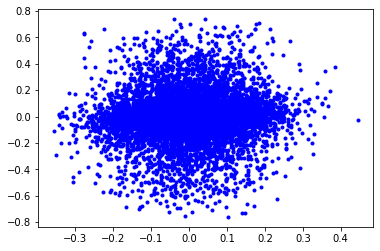

In [32]:
plt.plot(psf_e1, e1_pred,'b.')